In [1]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np

from plotly.subplots import make_subplots
from multiprocessing import Pool
from functools import partial
from utils import read_bm_data
from scipy.stats import ttest_rel, pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sktime.transformations.series.detrend import STLTransformer

import os
import ta
import pytz
import tqdm
import pickle

In [2]:
if os.path.exists('./large_files/cl-1m.pkl'):
    df_wti_1m = pickle.load(open('./large_files/cl-1m.pkl', 'rb'))
else:
    df_wti_1m = read_bm_data('./large_files/cl-1m.csv')
    pickle.dump(df_wti_1m, open('./large_files/cl-1m.pkl', 'wb'))

df_wti_1m = df_wti_1m[(df_wti_1m['datetime'].dt.hour >= 9) & (df_wti_1m['datetime'].dt.hour < 16)]

df_wti = read_bm_data('./data/backtestmarket/cl-15m.csv')
# take only wednesday data for 10 years

df = df_wti.copy()
df = df[(df['datetime'].dt.hour >= 9) & (df['datetime'].dt.hour < 16)]
df = df[(df['datetime'].dt.weekday == 2) & (df['datetime'].dt.year >= 2010) & (df['datetime'].dt.year <= 2019)]
df.head()

,date,time,open,high,low,close,volume,datetime,day
65918,2010-01-06,0900,81.84,81.92,81.67,81.80,5818,2010-01-06 09:00:00-05:00,Wednesday
65919,2010-01-06,0915,81.80,81.92,81.67,81.76,3187,2010-01-06 09:15:00-05:00,Wednesday
65920,2010-01-06,0930,81.76,81.90,81.67,81.73,4522,2010-01-06 09:30:00-05:00,Wednesday
65921,2010-01-06,0945,81.75,81.87,81.62,81.79,5741,2010-01-06 09:45:00-05:00,Wednesday
65922,2010-01-06,1000,81.79,81.97,81.74,81.87,4907,2010-01-06 10:00:00-05:00,Wednesday


In [3]:
# define some common time
NINE_THIRTY = pd.to_datetime('09:30:00')
TEN_THIRTY = pd.to_datetime('10:30:00')
ELEVEN = pd.to_datetime('11:00:00')
TWELVE = pd.to_datetime('12:00:00')

# Targets?
1. Predict next hour (relative to 1030) mean (up / down / neutral)
1. Predict day close (4pm) (up / down / neutral)
1. (Use 1m data) For every 15m window, predict if the mean is closer to the high or low. Say price is going upward, before it hits the peak and make a u-turn, the mean within the window will be less close to the high.

In [4]:
def plot_candlestick(df, title='', column='high_dst_15m'):
    
    # fig = go.Figure()
    fig = make_subplots(specs=[[{'secondary_y': True}]])
    
    fig.add_trace(
        go.Candlestick(
            x=df['datetime'],
            open=df['open'],
            low=df['low'],
            high=df['high'],
            close=df['close'],
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df['datetime'],
            y=df[column],
            mode='lines'
        ),
        secondary_y=True
    )
    
    fig.update_layout(
        title=f'{title}',
        xaxis_title='Datetime',
        yaxis_title='Price ($)',
        xaxis_rangeslider_visible=False,
        width=2000,
        height=500,
        # template='plotly_dark',
        template='plotly',
        yaxis2=dict(range=[0.3, 0.7])
    )
    
    fig.show()

In [5]:
# test out idea 3

df_uturn = []
counter = 0
for day, df_day in tqdm.tqdm(df.groupby(pd.Grouper(key='datetime', freq='D'))):
    if df_day.shape[0] == 0:
        continue

    df_day_1m = df_wti_1m[
        (df_wti_1m['datetime'] >= df_day['datetime'].iloc[0]) &
        (df_wti_1m['datetime'] < (df_day['datetime'].iloc[-1] + pd.Timedelta(minutes=15)))
    ]

    distances = []
    for time_range, df_tmp in df_day_1m.groupby(pd.Grouper(key='datetime', freq='15min')):
        mean = df_tmp['close'].mean()
        high = df_tmp['high'].max()
        low = df_tmp['low'].min()
        # distance to high, approaching 0 means getting closer
        dist = (high - mean) / (high - low)
        distances.append({'datetime': pd.to_datetime(time_range), 'high_dst_15m': dist})
    distances = pd.DataFrame(distances)

    df_day = pd.merge(left=df_day, right=distances, how='left', on='datetime')
    df_uturn.append(df_day)

df_uturn = pd.concat(df_uturn).sort_values('datetime')
df_uturn.head()

 48%|████▊     | 1759/3634 [00:02<00:03, 610.62it/s]/tmp/ipykernel_15689/1676407654.py:20: RuntimeWarning: invalid value encountered in scalar divide
  dist = (high - mean) / (high - low)
100%|██████████| 3634/3634 [00:05<00:00, 622.66it/s]


,date,time,open,high,low,close,volume,datetime,day,high_dst_15m
0,2010-01-06,0900,81.84,81.92,81.67,81.80,5818,2010-01-06 09:00:00-05:00,Wednesday,0.632000
1,2010-01-06,0915,81.80,81.92,81.67,81.76,3187,2010-01-06 09:15:00-05:00,Wednesday,0.653333
2,2010-01-06,0930,81.76,81.90,81.67,81.73,4522,2010-01-06 09:30:00-05:00,Wednesday,0.692754
3,2010-01-06,0945,81.75,81.87,81.62,81.79,5741,2010-01-06 09:45:00-05:00,Wednesday,0.477333
4,2010-01-06,1000,81.79,81.97,81.74,81.87,4907,2010-01-06 10:00:00-05:00,Wednesday,0.452174


In [6]:
# test out idea 3

df_uturn2 = []
for day, df_day in tqdm.tqdm(df.groupby(pd.Grouper(key='datetime', freq='D'))):
    if df_day.shape[0] == 0:
        continue

    df_day_1m = df_wti_1m[
        (df_wti_1m['datetime'] >= df_day['datetime'].iloc[0]) &
        (df_wti_1m['datetime'] < (df_day['datetime'].iloc[-1] + pd.Timedelta(minutes=5)))
    ]

    distances = []
    for time_range, df_tmp in df_day_1m.groupby(pd.Grouper(key='datetime', freq='5min')):
        mean = df_tmp['close'].mean()
        high = df_tmp['high'].max()
        low = df_tmp['low'].min()
        # distance to high, approaching 0 means getting closer
        dist = (high - mean) / (high - low)
        distances.append({'datetime': pd.to_datetime(time_range), 'high_dst_5m': dist})
    distances = pd.DataFrame(distances)

    df_day = pd.merge(left=df_day, right=distances, how='left', on='datetime')
    df_uturn2.append(df_day)

df_uturn2 = pd.concat(df_uturn2).sort_values('datetime')
df_uturn2.head()

 15%|█▍        | 533/3634 [00:01<00:08, 354.94it/s]/tmp/ipykernel_15689/2842932319.py:19: RuntimeWarning: invalid value encountered in scalar divide
  dist = (high - mean) / (high - low)
 49%|████▉     | 1786/3634 [00:05<00:05, 362.52it/s]/tmp/ipykernel_15689/2842932319.py:19: RuntimeWarning: invalid value encountered in scalar divide
  dist = (high - mean) / (high - low)
 55%|█████▍    | 1996/3634 [00:05<00:04, 357.96it/s]/tmp/ipykernel_15689/2842932319.py:19: RuntimeWarning: invalid value encountered in scalar divide
  dist = (high - mean) / (high - low)
100%|██████████| 3634/3634 [00:10<00:00, 353.43it/s]


,date,time,open,high,low,close,volume,datetime,day,high_dst_5m
0,2010-01-06,0900,81.84,81.92,81.67,81.80,5818,2010-01-06 09:00:00-05:00,Wednesday,0.720000
1,2010-01-06,0915,81.80,81.92,81.67,81.76,3187,2010-01-06 09:15:00-05:00,Wednesday,0.580000
2,2010-01-06,0930,81.76,81.90,81.67,81.73,4522,2010-01-06 09:30:00-05:00,Wednesday,0.600000
3,2010-01-06,0945,81.75,81.87,81.62,81.79,5741,2010-01-06 09:45:00-05:00,Wednesday,0.400000
4,2010-01-06,1000,81.79,81.97,81.74,81.87,4907,2010-01-06 10:00:00-05:00,Wednesday,0.452174


In [7]:
days = df_uturn['datetime'].dt.date.unique()
np.random.shuffle(days)

for day in days[:5]:
    df_day = df_uturn[df_uturn['datetime'].dt.date == day]
    plot_candlestick(df_day, day)

In [8]:
window_size = 4
sma_values = df_uturn.groupby(df_uturn['datetime'].dt.date)['high_dst_15m'].rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)
df_uturn['high_dst_15m_sma'] = sma_values

for day in days[:5]:
    df_day = df_uturn[df_uturn['datetime'].dt.date == day]
    plot_candlestick(df_day, day, 'high_dst_15m_sma')

In [9]:
window_size = 4
sma_values = df_uturn2.groupby(df_uturn2['datetime'].dt.date)['high_dst_5m'].rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)
df_uturn2['high_dst_5m_sma'] = sma_values

for day in days[:3]:
    df_day = df_uturn2[df_uturn2['datetime'].dt.date == day]
    plot_candlestick(df_day, day, 'high_dst_5m_sma')

# Defining up, down and neutral

In [10]:
df_result = []
for day, df_day in tqdm.tqdm(df.groupby(pd.Grouper(key='datetime', freq='D'))):
    # 1030
    df_1030 = df_day[(df_day['datetime'].dt.time >= TEN_THIRTY.time())]

    # the grouper function will generate every day sequentially even if
    # it is not in dataframe
    if (df_1030.shape[0] == 0) or (day.strftime('%A') != 'Wednesday'):
        continue
    price = df_1030['close'].values[0]

    # past hour
    df_past = df_day[
        (df_day['datetime'].dt.time >= NINE_THIRTY.time()) &
        (df_day['datetime'].dt.time < TEN_THIRTY.time())
    ]
    past_mean = df_past['close'].mean()
    past_std = df_past['close'].std()
    z = (price - past_mean) / past_std
    pct_past = np.round(((price - past_mean) / past_mean) * 100, 2)

    result = {
        'date': df_1030['datetime'].iloc[0],
        '1030_close': price,
        'z': z,
        'pct_past': pct_past,
        'past_mean': past_mean,
    }
    df_result.append(result)

df_result = pd.DataFrame(df_result)
df_result.head(5)

100%|██████████| 3634/3634 [00:01<00:00, 2518.13it/s]


,date,1030_close,z,pct_past,past_mean
0,2010-01-06 10:30:00-05:00,81.24,-2.566472,-0.84,81.9275
1,2010-01-13 10:30:00-05:00,78.87,-2.429735,-0.88,79.5700
2,2010-01-20 10:30:00-05:00,77.49,-1.051497,-0.37,77.7775
3,2010-01-27 10:30:00-05:00,74.15,-2.891874,-0.51,74.5300
4,2010-02-03 10:30:00-05:00,77.11,-1.885800,-0.32,77.3575


In [11]:
df_result.describe()

,1030_close,z,pct_past,past_mean
count,518.000000,518.000000,518.000000,518.000000
mean,72.472278,-0.008611,0.023378,72.463789
std,21.881305,4.684590,0.549260,21.898777
min,28.030000,-33.935934,-3.180000,27.817500
25%,52.460000,-1.287411,-0.220000,52.378125
50%,71.705000,0.246098,0.035000,71.347500
75%,93.482500,1.488642,0.280000,93.501250
max,112.300000,37.328178,2.680000,112.322500


<Axes: >

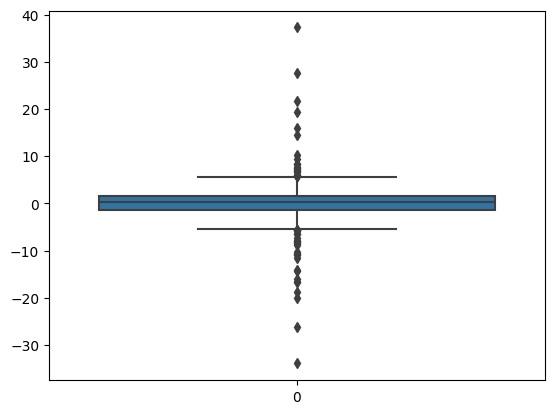

In [12]:
sns.boxplot(data=df_result['z'])

In [13]:
df_pos = df_result[df_result['z'] >= 0]
df_neg = df_result[df_result['z'] < 0]

display(df_pos.describe())
display(df_neg.describe())

,1030_close,z,pct_past,past_mean
count,285.000000,285.000000,285.000000,285.000000
mean,71.158246,2.316690,0.357579,70.928035
std,21.632040,3.674623,0.404728,21.618157
min,28.030000,0.000000,0.000000,27.817500
25%,52.250000,0.695019,0.100000,52.017500
50%,67.510000,1.370497,0.230000,67.480000
75%,93.400000,2.513315,0.460000,93.245000
max,108.620000,37.328178,2.680000,108.545000


,1030_close,z,pct_past,past_mean
count,233.000000,233.000000,233.000000,233.000000
mean,74.079571,-2.852863,-0.385408,74.342285
std,22.122772,4.196179,0.408339,22.138903
min,28.310000,-33.935934,-3.180000,28.560000
25%,52.950000,-2.963892,-0.510000,52.995000
50%,76.170000,-1.506891,-0.270000,77.035000
75%,93.810000,-0.786759,-0.130000,93.972500
max,112.300000,-0.019012,-0.010000,112.322500


In [14]:
# 20% quantile
pos_20_quant = df_pos['z'].quantile(0.2)
df_pos[df_pos['z'] <= pos_20_quant].describe()

,1030_close,z,pct_past,past_mean
count,57.000000,57.000000,57.000000,57.000000
mean,72.854211,0.261094,0.049649,72.821184
std,21.401158,0.143321,0.042425,21.400953
min,42.740000,0.000000,0.000000,42.720000
25%,51.120000,0.147979,0.020000,51.060000
50%,73.790000,0.292603,0.040000,73.780000
75%,91.280000,0.372189,0.070000,91.272500
max,106.100000,0.495434,0.170000,106.062500


In [15]:
df_pos[df_pos['z'] <= 0.5].sample(5)

,date,1030_close,z,pct_past,past_mean
345,2016-08-31 10:30:00-04:00,45.93,0.292603,0.03,45.9175
36,2010-09-15 10:30:00-04:00,75.27,0.338495,0.06,75.2225
59,2011-02-23 10:30:00-05:00,97.49,0.370773,0.13,97.3675
381,2017-05-10 10:30:00-04:00,46.57,0.149850,0.03,46.5575
488,2019-05-29 10:30:00-04:00,57.66,0.341276,0.15,57.5750


<Axes: ylabel='Frequency'>

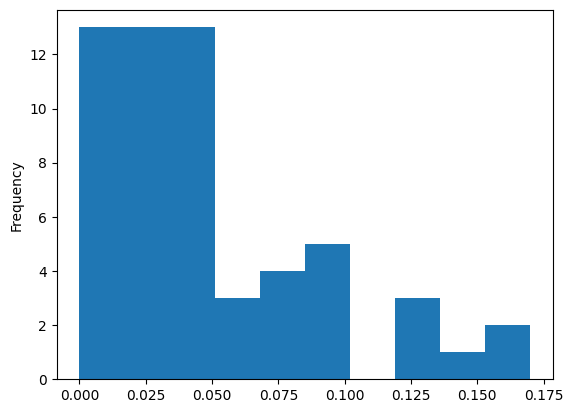

In [16]:
df_pos.loc[df_pos['z'] <= 0.5, 'pct_past'].plot.hist()

In [17]:
# 20% quantile
neg_20_quant = df_neg['z'].quantile(0.8)
df_neg[df_neg['z'] >= neg_20_quant].describe()

,1030_close,z,pct_past,past_mean
count,47.000000,47.000000,47.000000,47.000000
mean,72.669149,-0.301231,-0.076596,72.726011
std,21.907452,0.191467,0.080549,21.924043
min,36.750000,-0.642377,-0.390000,36.752500
25%,53.260000,-0.431885,-0.090000,53.287500
50%,67.650000,-0.302580,-0.060000,67.745000
75%,93.005000,-0.133189,-0.020000,93.082500
max,112.300000,-0.019012,-0.010000,112.322500


In [18]:
df_neg[df_neg['z'] >= -0.5].sample(5)

,date,1030_close,z,pct_past,past_mean
50,2010-12-22 10:30:00-05:00,90.50,-0.434099,-0.06,90.5500
503,2019-09-11 10:30:00-04:00,57.69,-0.268802,-0.10,57.7475
425,2018-03-14 10:30:00-04:00,60.99,-0.309757,-0.07,61.0325
156,2013-01-02 10:30:00-05:00,93.49,-0.054858,-0.01,93.4975
377,2017-04-12 10:30:00-04:00,53.57,-0.213201,-0.02,53.5800


<Axes: ylabel='Frequency'>

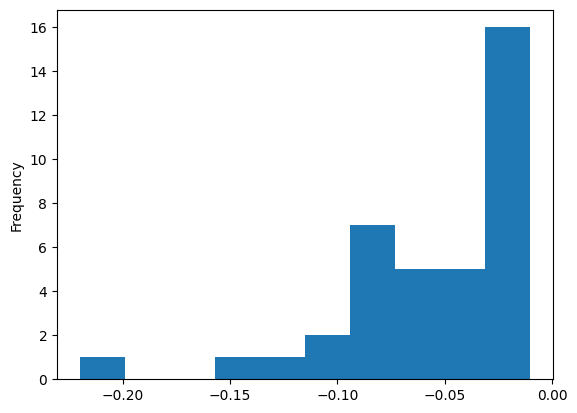

In [19]:
df_neg.loc[df_neg['z'] >= -0.5, 'pct_past'].plot.hist()

- Use 15 minutes data
- z-score relative to past hour mean
- 0 < z < 0.5, percentage change < 0.175 %
- -0.5 < z < 0, percentage change < 0.2 %
- -0.5 < z < 0.5 = neutral

# Features

### Z score relative to past time periods

Notes:
1. In the 15m data, sometimes there may have few consecutive time stamps recording the same closing price and the std will be 0.
1. Although we use the 15m data for the overall experiment, the mean and std are computed using the 1m data

In [20]:
def z_past(sr, lag_hr, lag_minute, name):
    timestamp = sr['datetime']
    start = timestamp - pd.Timedelta(hours=lag_hr, minutes=lag_minute)
    df_past = df_wti_1m[
        (df_wti_1m['datetime'] >= start) & 
        (df_wti_1m['datetime'] < timestamp)
    ]

    if df_past.shape[0] == 0:
        mean = sr['close']
        std = 0
        z = 0
    else:
        mean = df_past['close'].mean()
        std = df_past['close'].std()

        # prevent division by 0
        if std == 0:
            std = np.nan

        z = (sr['close'] - mean) / std

    sr[f'z_{name}'] = z
    sr[f'mean_{name}'] = mean
    sr[f'std_{name}'] = std
    if z > 0.5:
        sr[f'direction_{name}'] = 'up'
    elif z < -0.5:
        sr[f'direction_{name}'] = 'down'
    else:
        sr[f'direction_{name}'] = 'neutral'

    return sr

In [21]:
df_data_sr = df.to_dict(orient='records')
partial_function = partial(z_past, lag_hr=1, lag_minute=0, name='1hr')
with Pool(10) as p:
    df_data = list(tqdm.tqdm(p.starmap(partial_function, [(element,) for element in df_data_sr])))
df_data = pd.DataFrame(df_data)

100%|██████████| 14479/14479 [00:00<00:00, 6845054.96it/s]


In [22]:
df_data_sr = df_data.to_dict(orient='records')
partial_function = partial(z_past, lag_hr=0, lag_minute=30, name='30m')
with Pool(10) as p:
    df_data = list(tqdm.tqdm(p.starmap(partial_function, [(element,) for element in df_data_sr])))
df_data = pd.DataFrame(df_data)

100%|██████████| 14479/14479 [00:00<00:00, 5981417.08it/s]


<Axes: ylabel='direction_30m'>

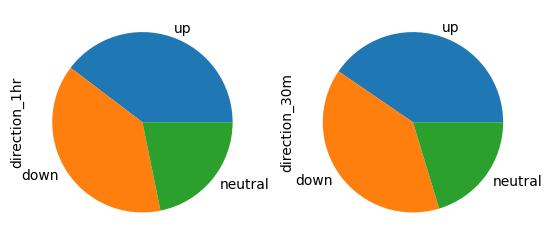

In [23]:
fig, ax = plt.subplots(1, 2)
df_data['direction_1hr'].value_counts().plot.pie(ax=ax[0])
df_data['direction_30m'].value_counts().plot.pie(ax=ax[1])

<Axes: xlabel='z_1hr', ylabel='z_30m'>

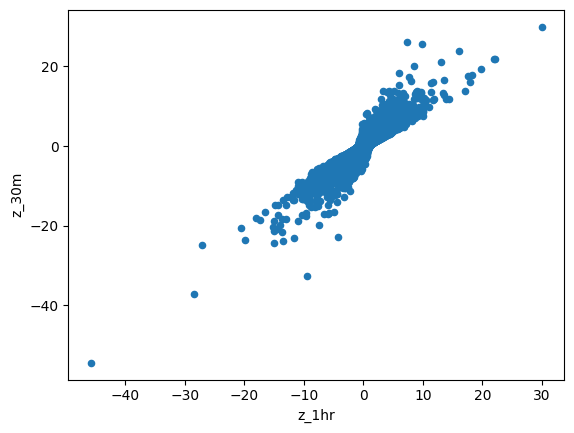

In [24]:
df_data.plot.scatter(x='z_1hr', y='z_30m')

In [30]:
df_data['high_dst_15m_sma'] = df_uturn['high_dst_15m_sma'].values
df_data['high_dst_5m_sma'] = df_uturn2['high_dst_5m_sma'].values

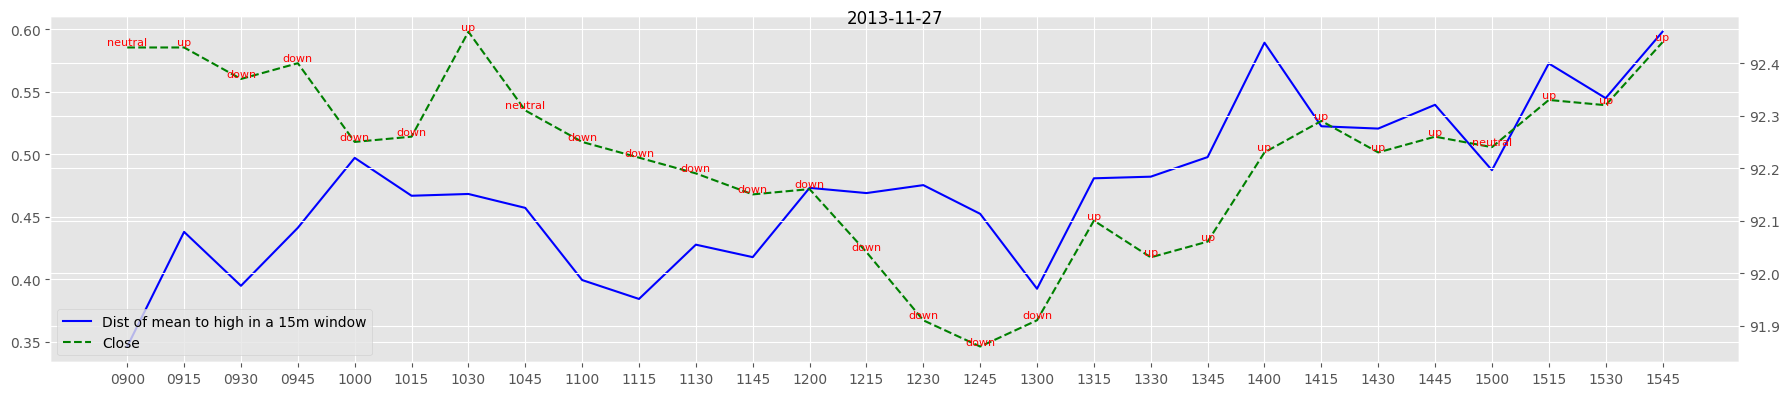

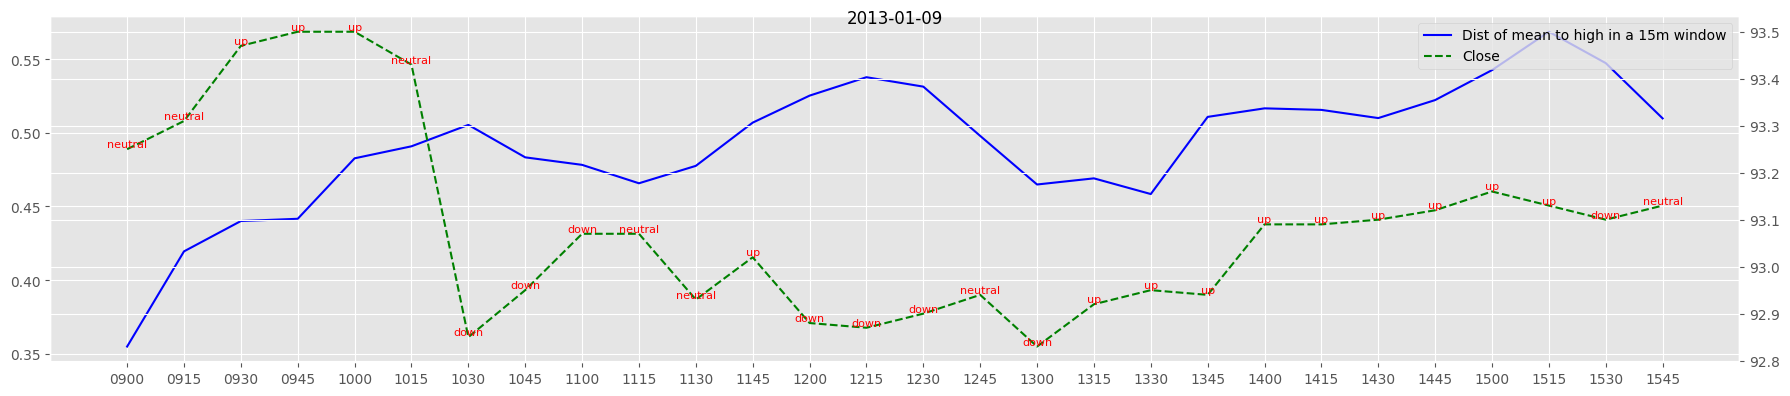

In [28]:
days = df_data['datetime'].dt.date.unique()
np.random.shuffle(days)

plt.style.use('ggplot')
for day in days[:2]:
    df_day = df_data[df_data['datetime'].dt.date == day]
    df_day = df_day.reset_index(drop=True)
    fig, ax1 = plt.subplots(figsize=(18, 4))
    line1 = ax1.plot(df_day['time'], df_day['high_dst_15m_sma'], color='blue', label='Dist of mean to high in a 15m window')
        
    ax2 = ax1.twinx() 
    line2 = ax2.plot(df_day['time'], df_day['close'], color='green', linestyle='--', label='Close')

    for i, direction in enumerate(df_day['direction_1hr']):
        ax2.text(df_day.loc[i, 'time'], df_day.loc[i, 'close'], direction,
                ha='center', va='bottom', fontsize=8, color='red')
    
    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.suptitle(day)

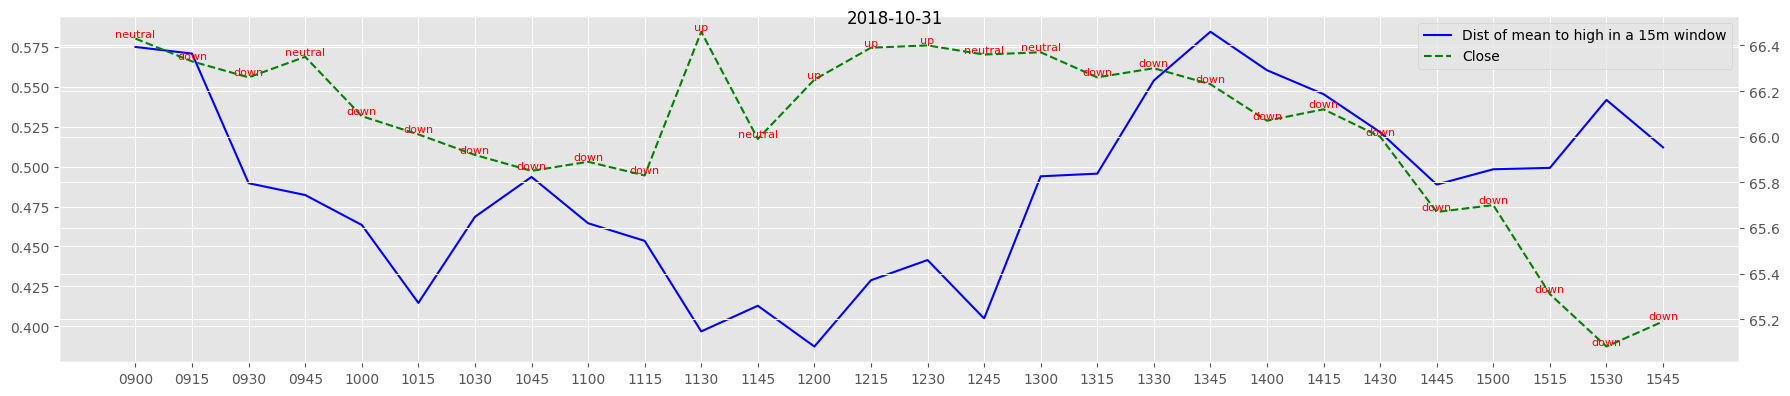

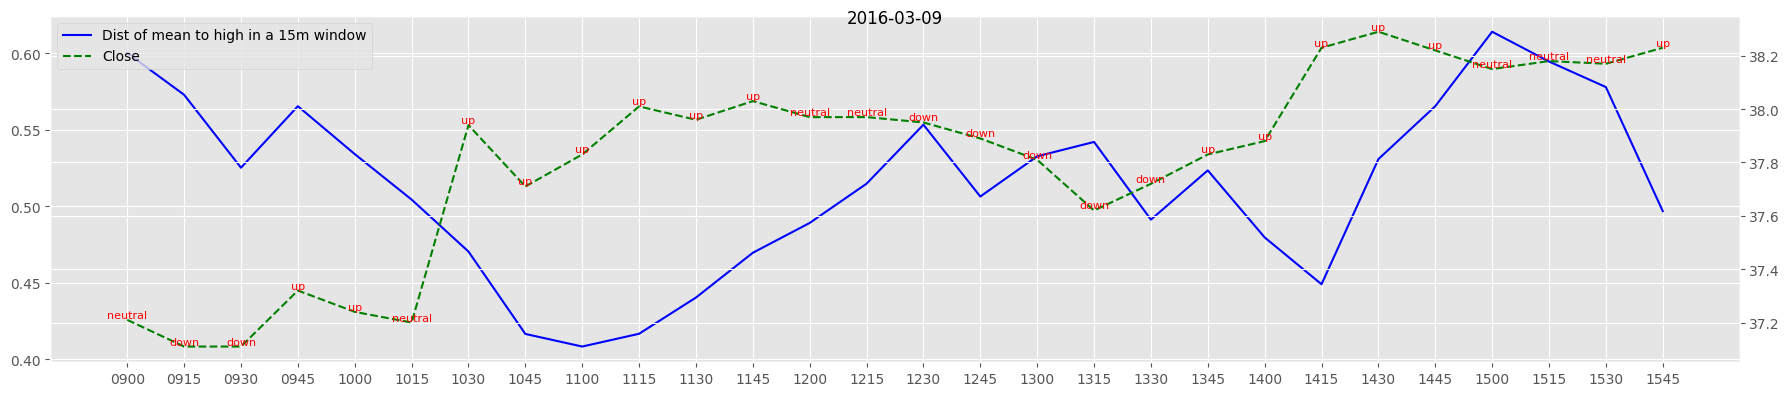

In [32]:
days = df_data['datetime'].dt.date.unique()
np.random.shuffle(days)

plt.style.use('ggplot')
for day in days[:2]:
    df_day = df_data[df_data['datetime'].dt.date == day]
    df_day = df_day.reset_index(drop=True)
    fig, ax1 = plt.subplots(figsize=(18, 4))
    line1 = ax1.plot(df_day['time'], df_day['high_dst_5m_sma'], color='blue', label='Dist of mean to high in a 15m window')
        
    ax2 = ax1.twinx() 
    line2 = ax2.plot(df_day['time'], df_day['close'], color='green', linestyle='--', label='Close')

    for i, direction in enumerate(df_day['direction_1hr']):
        ax2.text(df_day.loc[i, 'time'], df_day.loc[i, 'close'], direction,
                ha='center', va='bottom', fontsize=8, color='red')
    
    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.suptitle(day)

# Trend

# Momentum

# Target